# Initialisation GasConsumption and VWAP

In [952]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

path='Hedging/HedgeQuarter.xlsx'
xls=pd.ExcelFile(path)
Forward=pd.read_excel(xls,'ForwardPriceMonthly') #Par Mois laisse en mois
VWAP_customers=pd.read_excel(xls,'VWAPCustomers') #Par mois laisse en mois
Consumption_gas=pd.read_excel(xls,'ComsumptionGas2018-2019') #Par Heure passe par mois
#On vas tout convertir par mois car plus simple, pour les heures->jour->mois


#On commence par convertir
def Convert_hourtomonthcons(Consumption_gas):    
    s=0
    Conso_gasmois=[]
    for i in range(len(Consumption_gas)-1):
        s=s+Consumption_gas['Gas'][i]
        if Consumption_gas['Date'][i+1].month!=Consumption_gas['Date'][i].month:
            Conso_gasmois.append(s)
            s=0
    return Conso_gasmois

def Convert_hourtodaycons(Consumption_gas):    
    s=0
    Conso_gasday=[]
    for i in range(len(Consumption_gas)-1):
        s=s+Consumption_gas['Gas'][i]
        if Consumption_gas['Date'][i+1].day!=Consumption_gas['Date'][i].day:
            Conso_gasday.append(s)
            s=0
    return Conso_gasday

ConsomationGasMonth=Convert_hourtomonthcons(Consumption_gas) #Conversion d'heure a mois

Consumption_gas=pd.DataFrame(ConsomationGasMonth,index=pd.date_range(start = pd.to_datetime('2018-01'),
                             periods = len(ConsomationGasMonth), freq='M'), columns = ['Conso Gas']) # consommation de gas KWH
VWAP_customers=pd.DataFrame(VWAP_customers['VWAP_customers'].values,index=pd.date_range(start = pd.to_datetime('2018-01'),
                             periods = len(VWAP_customers), freq='M'), columns = ['VWAP_customers'])

# Iniatialisation of gas price over 2016

In [953]:
dataforward=pd.ExcelFile('ForwardPrice2016.xlsx')
gas=pd.read_excel(dataforward,'Gas')
gas.keys()
gas=gas.drop('Delivery\Today',1)


In [954]:

gas=pd.DataFrame(gas.values,index=pd.date_range(start = pd.to_datetime('2017-01-01'),
                             periods = len(gas), freq='M'),columns=gas.keys())

## Creation of a Dataframe which do a synthesis of all the Data per month

In [955]:
synthese=VWAP_customers.merge(Consumption_gas,right_index=True,left_index=True)

# Choose of Today Date, for the Forward Price

In [956]:
Today=pd.to_datetime('23-09-2016')
synthese=synthese.merge(gas[Today],right_index=True,left_index=True)
synthese=synthese.rename(columns={Today:'Today'})


# Function calculating the moving Average

In [957]:
def calcul_MM(gas,nbr_week): #MM
    Total=[]
    for i in gas.index:
        mois=[]
        for j in gas.keys():
            s=np.mean(gas.loc[i,j-timedelta(days=nbr_week*7):j])
            mois.append(s)
        Total.append(mois)
    return Total
TotalMM20=calcul_MM(gas,2)
MM20=pd.DataFrame(TotalMM20,index=pd.date_range(start = pd.to_datetime('2017-01-01'),
                             periods = len(gas), freq='M'),columns=gas.keys()) #CalculMM20

# Vision of the moving average 20 Days, it smooth the curve

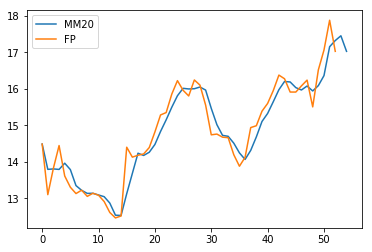

In [958]:
plt.plot(TotalMM20[5][:],label='MM20')
plt.plot(gas.loc[pd.to_datetime('2017-06-30')].values,label='FP')

plt.legend()

# Adding the Moving average to the synthesis

In [959]:
synthese=synthese.merge(MM20[Today],left_index=True,right_index=True)

# Defining the Date of the previous Week, and put the moving average in the synthesis

In [960]:
LastWeek=Today-timedelta(days=7)

In [961]:
synthese=synthese.merge(MM20[LastWeek],left_index=True,right_index=True)

# Function which gives the signal to Hedge !!!

In [962]:
def calcul_delta_prix(MarketPrice, VWAP):
    #On calcule le poucentage du delta
    return (MarketPrice/VWAP)-1

def calcul_percentage(Today,index):
    Timeofdelivery_week=((index-Today).days)/52
    return (np.sqrt(Timeofdelivery_week)*2)/100



def Signal(MarketPrice,VWAP,TodayMM20,LastWeekMM20):
    Etat=[]
    for i in range(len(VWAP)):
        if MarketPrice[i]>VWAP[i]+0.1 and TodayMM20[i]>LastWeekMM20[i]+0.20: #the market price above 1 euros avec the mm superiour than last week by 0,15 cents            15
            Etat.append('Long')

        elif MarketPrice[i]>VWAP[i]+0.1 and TodayMM20[i]<LastWeekMM20[i]-0.20:
            Etat.append('Short')

        elif MarketPrice[i]<VWAP[i]-0.1 and TodayMM20[i]>LastWeekMM20[i]+0.20:
            Etat.append('Long')

        elif MarketPrice[i]<VWAP[i]-0.1 and TodayMM20[i]<LastWeekMM20[i]-0.20:
            Etat.append('Short')

        else:
            Etat.append('Flat')
            
    return Etat




# Putting the state in the synthesis

In [963]:
synthese['Etat']=Signal(synthese['Today'],synthese['VWAP_customers'],synthese[Today],synthese[LastWeek])

# put the gas consumption in MWH

In [964]:
synthese['Conso Gas']=synthese['Conso Gas']/1000

# Putting the previous hedge to 0

In [965]:
synthese['PreviousHedge']=0.

# Function for the hedging strategy 

In [966]:
def calculate_volume_hedged(MMToday,MMLastWeek,Volume):
    Delta=MMToday-MMLastWeek
    if Delta >4:
        return 1.2*Volume
    elif Delta>=0 and Delta<=4:
        return ((Volume*np.sqrt(Delta))/(np.pi))+Volume
    elif Delta >-4 and Delta<0  :
        return (-(Volume*np.sqrt(-(Delta)))/(np.pi))+Volume
    else:
        return 0.8*Volume
    
def Volatility(today,Tdelivery): #en jour
    if ((Tdelivery-today).days/90)<(30/90):
        return (1/5)*(30/90)**(-2/5)
    else:
        return (1/5)*((Tdelivery-today).days/90)**(-2/5)
    
def coef_aggresivity(volatility,cst_aggresivity): #calcul du coefficient d'agressivity
    return 1.2-volatility-cst_aggresivity


def calcul_upperPrice(upperPriceBase,volatility,cst_aggresivity):
    return upperPriceBase*coef_aggresivity(volatility,cst_aggresivity) #Calcul de l'upperprice

def calcul_volume(BoundPrice,ForwardPrice,VWAP,upperPrice,VolumeBase,previous_hedge): #Calcul du volume
    Delta=ForwardPrice-VWAP
    return (((BoundPrice/upperPrice)*VolumeBase)*Delta) - previous_hedge
    
    


    
def Hedging2(ForwardPrice,VWAP,Volume,Today,Etat,upperPriceBase,cst_agressivity,previousHedge,BoundPrice):
    Volume=-Volume
    VolumeHedged=[]
    ValueHedged=[]
    print(' Hedging Strategy for '+str(Today.day)+'-'+str(Today.month)+'-'+str(Today.year)+' :')
    
    for i in range(len(ForwardPrice)):
        if Etat[i]=='Short':
                volatility=Volatility(Today,Etat.index[i])
                upperPrice=calcul_upperPrice(upperPriceBase,volatility,cst_agressivity)
                new_volume=calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i])
                ValueSell=-(new_volume*ForwardPrice[i]) - (0.1*new_volume) 
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                else:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
        elif Etat[i]=='Long':
                volatility=Volatility(Today,Etat.index[i])
                upperPrice=calcul_upperPrice(upperPriceBase,volatility,cst_agressivity)
                new_volume=calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i])
                ValueSell=-(new_volume*ForwardPrice[i]) - (0.1*new_volume)
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros' % (Etat.index[i].year,Etat.index[i].month,abs(new_volume),ValueSell))
                else:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros' % (Etat.index[i].year,Etat.index[i].month,abs(new_volume),ValueSell))   
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
        else :
                VolumeHedged.append(0)
                ValueHedged.append(0)
    return (VolumeHedged,ValueHedged)
    
    
    
    
    
    
    
    
    

def Hedging(ForwardPrice,VWAP,MMToday,MMLastWeek,Volume,Today,Etat):
    ValueHedged=[]
    VolumeHedged=[]
    Volume=-Volume
    print(' Hedging Strategy for '+str(Today.day)+'-'+str(Today.month)+'-'+str(Today.year)+' :')
    
    for i in range(len(ForwardPrice)):
        if Etat[i]=='Short':
            new_volume=calculate_volume_hedged(MMToday[i],MMLastWeek[i],Volume[i])
            ValueSell=(new_volume-Volume[i])*ForwardPrice[i]
            print('For Delivery in %d-%d ,Sold %f MWH,and the value is %f Euros' % (Etat.index[i].year,Etat.index[i].month,(new_volume-Volume[i]),ValueSell))
            VolumeHedged.append(new_volume)
            ValueHedged.append(ValueSell)
        elif Etat[i]=='Long':
            new_volume=calculate_volume_hedged(MMToday[i],MMLastWeek[i],Volume[i])
            ValueBuy=((new_volume-Volume[i]))*ForwardPrice[i]
            print('For Delivery in %d-%d ,Buy %f MWH,and the value is %f Euros' % ( Etat.index[i].year ,Etat.index[i].month,(new_volume-Volume[i]),ValueBuy))
            VolumeHedged.append(new_volume)
            ValueHedged.append(ValueBuy)
        else :
            VolumeHedged.append(0)
            ValueHedged.append(0)
    
    return (VolumeHedged,ValueHedged)






In [967]:
Hedge=Hedging(synthese['Today'],synthese['VWAP_customers'],synthese[Today],synthese[LastWeek],synthese['Conso Gas'],Today,synthese['Etat'])

 Hedging Strategy for 23-9-2016 :
For Delivery in 2018-4 ,Buy 196.439739 MWH,and the value is 3119.205238 Euros
For Delivery in 2018-5 ,Buy 135.523952 MWH,and the value is 2087.975430 Euros
For Delivery in 2018-6 ,Buy 133.839197 MWH,and the value is 2044.862484 Euros
For Delivery in 2018-7 ,Buy 133.977356 MWH,and the value is 2068.409852 Euros
For Delivery in 2018-8 ,Buy 135.287125 MWH,and the value is 2123.189070 Euros
For Delivery in 2018-9 ,Buy 159.518101 MWH,and the value is 2549.015443 Euros
For Delivery in 2018-10 ,Buy 295.107117 MWH,and the value is 4817.185016 Euros
For Delivery in 2018-11 ,Buy 453.602499 MWH,and the value is 7563.884901 Euros
For Delivery in 2018-12 ,Buy 642.627642 MWH,and the value is 10940.920412 Euros
For Delivery in 2019-1 ,Buy 5695.298703 MWH,and the value is 98901.894524 Euros
For Delivery in 2019-2 ,Buy 5140.836622 MWH,and the value is 88972.943956 Euros
For Delivery in 2019-3 ,Buy 4491.947921 MWH,and the value is 75439.007217 Euros
For Delivery in 2019

In [968]:
cst_agressivity=0. #constante empirique
upperPriceBase=4 #Calcul grace a la variation standart

Hedgi=Hedging2(synthese['Today'],synthese['VWAP_customers'],synthese['Conso Gas'],Today,synthese['Etat'],upperPriceBase,cst_agressivity,synthese['PreviousHedge'],0.2)

 Hedging Strategy for 23-9-2016 :
For Delivery in 2018-4 ,Sold 110.017387 MWH,and we receive is 1746.931712 Euros
For Delivery in 2018-5 ,Sold 91.031814 MWH,and we receive is 1402.498876 Euros
For Delivery in 2018-6 ,Sold 102.595730 MWH,and we receive is 1567.509097 Euros
For Delivery in 2018-7 ,Sold 100.168079 MWH,and we receive is 1546.445221 Euros
For Delivery in 2018-8 ,Sold 91.310069 MWH,and we receive is 1433.015458 Euros
For Delivery in 2018-9 ,Sold 95.480678 MWH,and we receive is 1525.731066 Euros
For Delivery in 2018-10 ,Sold 158.587011 MWH,and we receive is 2588.697223 Euros
For Delivery in 2018-11 ,Sold 214.556070 MWH,and we receive is 3577.752386 Euros
For Delivery in 2018-12 ,Sold 304.855440 MWH,and we receive is 5190.251535 Euros
For Delivery in 2019-1 ,Sold 5115.116734 MWH,and we receive is 88826.725710 Euros
For Delivery in 2019-2 ,Sold 4736.840829 MWH,and we receive is 81980.950694 Euros
For Delivery in 2019-3 ,Sold 4845.216978 MWH,and we receive is 81371.904804 Euros


# Vue of synthese

In [969]:
synthese

,VWAP_customers,Conso Gas,Today,2016-09-23 00:00:00,2016-09-16 00:00:00,Etat,PreviousHedge
2018-01-31,17.791018,-2313.432807,17.074686,16.569187,16.376859,Flat,0.0
2018-02-28,17.792241,-2043.327181,17.007285,16.505285,16.312524,Flat,0.0
2018-03-31,17.762505,-1877.761861,16.570338,16.068934,15.869239,Flat,0.0
2018-04-30,17.691166,-1341.883546,15.878688,15.375273,15.163764,Long,0.0
2018-05-31,17.626902,-908.000000,15.406689,14.899984,14.680117,Long,0.0
2018-06-30,17.832523,-891.000000,15.278502,14.767605,14.544910,Long,0.0
2018-07-31,17.924734,-895.000000,15.438503,14.923564,14.702399,Long,0.0
2018-08-31,17.935999,-906.000000,15.693948,15.179263,14.959195,Long,0.0
2018-09-30,17.972764,-1067.000000,15.979475,15.470326,15.249733,Long,0.0
2018-10-31,18.123518,-1965.000000,16.323514,15.823461,15.600857,Long,0.0


# SIMULATION

In [970]:
synthese['PreviousHedge']=0.
synthese['Valueofhedge']=0.
synthese['Nbr transaction']=0
del synthese[Today]
del synthese[LastWeek]
for date in gas.keys()[16:50]:
    Today=date
    LastWeek=Today-timedelta(days=7)
    #ForwardPrice
    del synthese['Today']
    synthese=synthese.merge(gas[Today],right_index=True,left_index=True)
    synthese=synthese.rename(columns={Today:'Today'})
    #MM20
    synthese=synthese.merge(MM20[Today],left_index=True,right_index=True)
    synthese=synthese.merge(MM20[LastWeek],left_index=True,right_index=True)
    synthese['Etat']=Signal(synthese['Today'],synthese['VWAP_customers'],synthese[Today],synthese[LastWeek])
    for i in range(len(synthese)):
        if synthese['Etat'][i]=='Short' or synthese['Etat'][i]=='Long':
            synthese['Nbr transaction'][i]=synthese['Nbr transaction'][i]+1
    Hedgi=Hedging2(synthese['Today'],synthese['VWAP_customers'],synthese['Conso Gas'],Today,synthese['Etat'],upperPriceBase,cst_agressivity,synthese['PreviousHedge'],0.2)
    synthese['PreviousHedge']=synthese['PreviousHedge']+Hedgi[0]
    synthese['Valueofhedge']=synthese['Valueofhedge']+Hedgi[1]
    
    
    
    del synthese[Today]
    del synthese[LastWeek]

C:\Users\sasma\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 Hedging Strategy for 29-4-2016 :
For Delivery in 2018-1 ,Sold 151.811117 MWH,and we receive is 2479.943384 Euros
For Delivery in 2018-2 ,Sold 137.481926 MWH,and we receive is 2240.681702 Euros
For Delivery in 2018-3 ,Sold 157.884470 MWH,and we receive is 2509.182777 Euros
For Delivery in 2018-4 ,Sold 148.090630 MWH,and we receive is 2255.939468 Euros
For Delivery in 2018-5 ,Sold 115.635449 MWH,and we receive is 1709.926665 Euros
For Delivery in 2018-6 ,Sold 125.979699 MWH,and we receive is 1848.890514 Euros
For Delivery in 2018-7 ,Sold 123.499290 MWH,and we receive is 1832.823370 Euros
For Delivery in 2018-8 ,Sold 115.902086 MWH,and we receive is 1747.082609 Euros
For Delivery in 2018-9 ,Sold 126.998795 MWH,and we receive is 1943.981434 Euros
For Delivery in 2018-10 ,Sold 222.839078 MWH,and we receive is 3472.104115 Euros
For Delivery in 2018-11 ,Sold 318.021779 MWH,and we receive is 5054.465830 Euros
For Delivery in 2018-12 ,Sold 449.479265 MWH,and we receive is 7302.639814 Euros
For

 Hedging Strategy for 10-6-2016 :
For Delivery in 2018-1 ,Buy 27.667770 MWH,and we pay is -479.100551 Euros
For Delivery in 2018-2 ,Buy 24.105604 MWH,and we pay is -416.087900 Euros
For Delivery in 2018-3 ,Buy 22.967189 MWH,and we pay is -386.158745 Euros
For Delivery in 2018-4 ,Buy 17.589819 MWH,and we pay is -283.109011 Euros
For Delivery in 2018-5 ,Buy 12.411598 MWH,and we pay is -193.757535 Euros
For Delivery in 2018-6 ,Buy 12.226878 MWH,and we pay is -189.434879 Euros
For Delivery in 2018-7 ,Buy 12.025078 MWH,and we pay is -188.499669 Euros
For Delivery in 2018-8 ,Buy 12.197627 MWH,and we pay is -194.206423 Euros
For Delivery in 2018-9 ,Buy 14.892909 MWH,and we pay is -240.613252 Euros
For Delivery in 2018-10 ,Buy 28.962232 MWH,and we pay is -475.534881 Euros
For Delivery in 2018-11 ,Buy 45.357906 MWH,and we pay is -757.676982 Euros
For Delivery in 2018-12 ,Buy 62.880150 MWH,and we pay is -1069.850008 Euros
For Delivery in 2019-1 ,Buy 528.778453 MWH,and we pay is -9169.977479 Euro

 Hedging Strategy for 5-8-2016 :
For Delivery in 2018-1 ,Sold -127.588745 MWH,and we receive is 2147.972947 Euros
For Delivery in 2018-2 ,Sold -107.139316 MWH,and we receive is 1796.168104 Euros
For Delivery in 2018-3 ,Sold -97.308483 MWH,and we receive is 1586.431518 Euros
For Delivery in 2018-4 ,Sold -71.061045 MWH,and we receive is 1106.395546 Euros
For Delivery in 2018-5 ,Sold -49.339354 MWH,and we receive is 743.245310 Euros
For Delivery in 2018-6 ,Sold -49.537722 MWH,and we receive is 738.926432 Euros
For Delivery in 2018-7 ,Sold -50.449934 MWH,and we receive is 760.423897 Euros
For Delivery in 2018-8 ,Sold -50.152167 MWH,and we receive is 769.598323 Euros
For Delivery in 2018-9 ,Sold -55.800744 MWH,and we receive is 874.336319 Euros
For Delivery in 2018-10 ,Sold -94.704385 MWH,and we receive is 1520.648512 Euros
For Delivery in 2018-11 ,Sold -140.877398 MWH,and we receive is 2310.058755 Euros
For Delivery in 2018-12 ,Sold -208.885417 MWH,and we receive is 3481.492193 Euros
For D

 Hedging Strategy for 9-9-2016 :
For Delivery in 2018-1 ,Sold -70.720159 MWH,and we receive is 1152.425788 Euros
For Delivery in 2018-2 ,Sold -60.899257 MWH,and we receive is 988.625429 Euros
For Delivery in 2018-3 ,Sold -52.168478 MWH,and we receive is 823.859525 Euros
 Hedging Strategy for 16-9-2016 :
 Hedging Strategy for 23-9-2016 :
For Delivery in 2018-4 ,Buy 14.466930 MWH,and we pay is -229.715868 Euros
For Delivery in 2018-5 ,Buy 11.770780 MWH,and we pay is -181.348747 Euros
For Delivery in 2018-6 ,Buy 11.877218 MWH,and we pay is -181.466103 Euros
For Delivery in 2018-7 ,Buy 11.095874 MWH,and we pay is -171.303688 Euros
For Delivery in 2018-8 ,Buy 10.979995 MWH,and we pay is -172.319467 Euros
For Delivery in 2018-9 ,Buy 13.830469 MWH,and we pay is -221.003629 Euros
For Delivery in 2018-10 ,Buy 28.887188 MWH,and we pay is -471.540407 Euros
For Delivery in 2018-11 ,Buy 49.531005 MWH,and we pay is -825.936419 Euros
For Delivery in 2018-12 ,Buy 76.587853 MWH,and we pay is -1303.9302

 Hedging Strategy for 21-10-2016 :
For Delivery in 2018-3 ,Buy 43.543461 MWH,and we pay is -759.564984 Euros
For Delivery in 2018-4 ,Buy 31.521998 MWH,and we pay is -530.415712 Euros
For Delivery in 2018-6 ,Buy 20.883022 MWH,and we pay is -334.962867 Euros
For Delivery in 2018-7 ,Buy 20.793921 MWH,and we pay is -331.880716 Euros
For Delivery in 2018-8 ,Buy 21.207917 MWH,and we pay is -341.238148 Euros
For Delivery in 2018-10 ,Buy 49.258537 MWH,and we pay is -833.466611 Euros
For Delivery in 2018-11 ,Buy 77.979474 MWH,and we pay is -1356.573662 Euros
For Delivery in 2018-12 ,Buy 112.578094 MWH,and we pay is -2003.395699 Euros
For Delivery in 2019-1 ,Buy 1009.356261 MWH,and we pay is -18292.838253 Euros
For Delivery in 2019-2 ,Buy 928.136071 MWH,and we pay is -16751.416276 Euros
For Delivery in 2019-3 ,Buy 833.931386 MWH,and we pay is -14617.839782 Euros
For Delivery in 2019-6 ,Buy 284.585973 MWH,and we pay is -4543.748197 Euros
For Delivery in 2019-7 ,Buy 281.353181 MWH,and we pay is -4

 Hedging Strategy for 2-12-2016 :
For Delivery in 2018-9 ,Buy 28.750669 MWH,and we pay is -476.550100 Euros
For Delivery in 2018-10 ,Buy 56.072412 MWH,and we pay is -955.722491 Euros
For Delivery in 2018-11 ,Buy 89.931364 MWH,and we pay is -1574.054778 Euros
For Delivery in 2018-12 ,Buy 130.971126 MWH,and we pay is -2345.866857 Euros
For Delivery in 2019-1 ,Buy 1175.802351 MWH,and we pay is -21480.371225 Euros
For Delivery in 2019-2 ,Buy 1060.163924 MWH,and we pay is -19308.824287 Euros
For Delivery in 2019-3 ,Buy 911.089102 MWH,and we pay is -16122.886856 Euros
For Delivery in 2019-4 ,Buy 607.810629 MWH,and we pay is -10245.124683 Euros
For Delivery in 2019-5 ,Buy 27.672378 MWH,and we pay is -450.489405 Euros
For Delivery in 2019-6 ,Buy 23.172293 MWH,and we pay is -373.423070 Euros
For Delivery in 2019-7 ,Buy 18.137090 MWH,and we pay is -295.869160 Euros
For Delivery in 2019-8 ,Buy 284.231108 MWH,and we pay is -4717.806892 Euros
For Delivery in 2019-9 ,Buy 347.109219 MWH,and we pay is

In [971]:
synthese.describe()

,VWAP_customers,Conso Gas,PreviousHedge,Valueofhedge,Nbr transaction,Today
count,60.000000,60.000000,60.000000,60.000000,60.000000,48.000000
mean,19.116814,-17273.111403,-1438.710476,21482.690071,11.166667,17.521432
std,0.793508,14941.285187,1522.839997,23162.240176,5.761258,0.638703
min,17.626902,-52672.281273,-5830.855542,-1185.863567,0.000000,16.356961
25%,18.619696,-30062.773067,-2442.983463,360.832855,12.000000,16.989524
50%,19.282759,-11479.756784,-1053.253952,15671.289251,13.000000,17.473260
75%,19.497510,-4025.201856,-41.993921,37171.185923,14.000000,18.072967
max,20.475836,-891.000000,38.041058,88516.419200,17.000000,18.612130


# Value given or received

In [972]:
synthese['Valueofhedge'].sum()

1288961.4042684687

In [973]:
Value_Portfolio=0
for i in range(len(synthese['Valueofhedge'])):
    Value_Portfolio=Value_Portfolio+synthese['VWAP_customers'][i]*(-synthese['Conso Gas'][i])

In [974]:
Value_Portfolio

20195175.043586142

In [975]:
100*(synthese['Valueofhedge'].sum()/Value_Portfolio)

6.3825215750127136

# TEST DU P&L

In [987]:
PL=pd.DataFrame(index=pd.date_range(start = pd.to_datetime('2018-01-31'),
                             periods = len(synthese), freq='M'))

In [988]:
PL['VWAP']=synthese['VWAP_customers']
PL['Spot Price']=synthese['Today'] #RANDOM EST FIXE
PL['Expected Conso']=-synthese['Conso Gas'] #consommation en positif
PL['Real Conso']=0
for i in range(len(synthese)):
    if PL['Spot Price'][i]>PL['VWAP'][i]:
        PL['Real Conso']=np.random.uniform(1,1.2,len(synthese))*PL['Expected Conso']
    else:
        PL['Real Conso']=np.random.uniform(0.8,1,len(synthese))*PL['Expected Conso']       
PL['Hedge Volume']=PL['Expected Conso']+synthese['PreviousHedge']
PL['Value Hedge']=synthese['Valueofhedge']
PL['PL Hedge']=PL['Real Conso']*PL['VWAP'] + PL['Value Hedge'] - PL['Expected Conso']*PL['VWAP'] -(PL['Real Conso']-PL['Hedge Volume'])*PL['Spot Price']
PL['PL Unhedged']=PL['Real Conso']*PL['VWAP'] - PL['Expected Conso']*PL['VWAP'] +(PL['Expected Conso']-PL['Real Conso'])*PL['Spot Price']

In [989]:
PL

,VWAP,Spot Price,Expected Conso,Real Conso,Hedge Volume,Value Hedge,PL Hedge,PL Unhedged
2018-01-31,17.791018,18.389955,2313.432807,1987.307862,2351.473865,-1185.863567,-290.961975,195.328242
2018-02-28,17.792241,18.365865,2043.327181,1797.522466,2073.476283,-1046.669143,-351.955275,140.999525
2018-03-31,17.762505,17.996674,1877.761861,1743.738865,1850.594592,143.235647,-314.300767,31.384086
2018-04-30,17.691166,17.377815,1341.883546,1177.073481,1266.590291,999.871127,-360.204437,-51.643285
2018-05-31,17.626902,16.889472,908.000000,750.444092,836.953495,900.198078,-415.926294,-116.186413
2018-06-30,17.832523,16.633269,891.000000,714.129662,842.597745,433.365257,-583.834954,-212.112460
2018-07-31,17.924734,16.591295,895.000000,727.940519,841.040476,524.308617,-593.713375,-222.763634
2018-08-31,17.935999,16.720705,906.000000,752.812727,856.302445,531.791365,-485.354420,-186.167622
2018-09-30,17.972764,16.996671,1067.000000,989.818103,1020.063862,541.469490,-331.625278,-75.336675
2018-10-31,18.123518,17.421352,1965.000000,1907.824092,1902.912593,646.174482,-475.619082,-40.146987


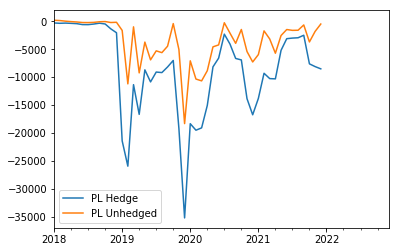

In [990]:
PL['PL Hedge'].plot()
PL['PL Unhedged'].plot()
plt.legend()